# De la représentation au machine learning

Un exemple parmi d'autres

- une représentation numérique
- un modèle (supevisé ou non supervisé) en fonction de la tâche

In [4]:
#!pip install scipy

## Charger les données

In [1]:
import pandas as pd
df = pd.read_csv("./data/dataframe.csv")
df.head()

,Unnamed: 0,numero,date,texte,texte_net
0,0,3063,03/06/2020,"</p><p align=""CENTER""> RÔLE DES COLLECTIVITÉS ...",RÔLE DES COLLECTIVITÉS LOCALES DANS LA LUTTE C...
1,1,3599,09/12/2020,"</p><p align=""CENTER""> CONTRÔLE DES EXPORTATIO...",CONTRÔLE DES EXPORTATIONS D'ARMEMENT M. le pré...
2,2,89,10/08/2017,"</p><p align=""CENTER""> TAXE DE SÉJOUR <a name=...",TAXE DE SÉJOUR M. le président. La parole est ...
3,3,348,29/11/2017,"</p><p align=""CENTER""> LISTE NOIRE DES PARADIS...",LISTE NOIRE DES PARADIS FISCAUX M. le présiden...
4,4,3433,21/10/2020,"</p><p align=""CENTER""> LUTTE CONTRE LE FINANCE...",LUTTE CONTRE LE FINANCEMENT DU TERRORISME M. l...


## Calculer une représentation tf-idf

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['texte_net'])

## Faire une classification hiérarchique ascendante


Calcule la distance entre chaque texte

In [6]:
Z = linkage(tfidf_matrix.toarray(), method='ward') 

Faire une représentation

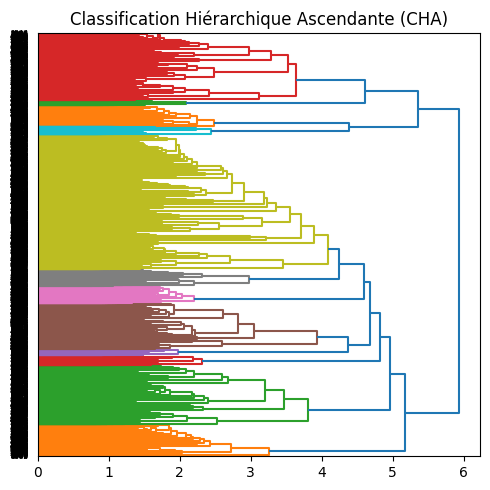

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
dendrogram(Z, orientation='right')
plt.title("Classification Hiérarchique Ascendante (CHA)")
plt.tight_layout()
plt.show()

Quels sont les questions les plus fréquentes ? Sont-elles posées sur les mêmes périodes ?

In [9]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=12,  linkage='ward')
labels = cluster.fit_predict(tfidf_matrix.toarray())
df['cluster'] = labels

In [11]:
df['cluster'].value_counts()

0     1543
4      768
1      679
2      521
3      366
6      249
8      201
5      190
11     115
9       88
10      71
7       59
Name: cluster, dtype: int64

Faire une représentation temporelle des clusters

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
df['date_val'] = pd.to_datetime(df['date'])
df.set_index('date_val').resample('ME')["cluster"].value_counts().unstack().plot(ax = ax);

### Quel est le contenu des clusters ?

Comment faire pour faire un résumé des clusters ? 

Une réponse : prendre la liste des mots les plus spécifiques

In [14]:
df_w = pd.DataFrame(tfidf_matrix.toarray(), 
                    columns=vectorizer.get_feature_names_out()) 

In [16]:
df_w[df["cluster"] == 3].max().sort_values()[-20:]

vietnam         0.459576
sahel           0.476618
raqqa           0.476782
britanniques    0.486635
schengen        0.487241
hezbollah       0.488382
cameroun        0.499767
iran            0.506251
russie          0.519686
tchad           0.521178
arménie         0.531633
g7              0.535722
mali            0.543667
libye           0.546106
paludisme       0.563212
liban           0.569404
irlande         0.576808
instex          0.590632
algérie         0.647363
taïwan          0.746740
dtype: float64

On peut améliorer :

- le choix des clusters
- la manière de résumer un cluster
- la représentation des textes
- le découpage des textes

## D'autres embeddings

Par exemple, les modèles fasttext https://fasttext.cc/

In [ ]:
from gensim.models.fasttext import load_facebook_vectors
import numpy as np

In [ ]:
# Télécharger ce modèle depuis https://fasttext.cc/docs/en/crawl-vectors.html
model = load_facebook_vectors('../../../../../../Documents/models/cc.fr.300.bin')

In [ ]:
def document_vector(words):
    word_vecs = [model[word] for word in words if word in model]
    return np.mean(word_vecs, axis=0) if word_vecs else np.zeros(model.vector_size)

# Matrice d'embeddings
X_embed = np.array([document_vector(doc) for doc in documents])
print(X_embed.shape)

Ou bien utiliser sbert https://sbert.net/ 

On voit apparaître de plus en plus de modèles

Ensuite la logique est la même...

## Empiler les traitements : BERTOPIC

Utiliser les différentes couches ensemble pour faire de la détection de thématiques : pipelines comme [BERTOPIC](https://maartengr.github.io/BERTopic/index.html)

![](../slides/img/bertopic.png)

[Faisons un test sur les données](https://maartengr.github.io/BERTopic/getting_started/quickstart/quickstart.html)


In [ ]:
import nltk
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import bertopic

nltk.download("stopwords")
french_stopwords = list(set(stopwords.words("french")))
vectorizer_model = CountVectorizer(stop_words=french_stopwords)
topic_model = bertopic.BERTopic(            language="french", 
            vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(df['texte'])

In [ ]:
topic_model.get_topic_info()